This dataset was sourced from data.gov.sg.

This dataset contains information on the resale prices of HDB flats in Singapore from January 2017 to June 2024. It includes detailed data on transaction month, town, flat type, block, street name, storey range, floor area, flat model, lease commencement date, remaining lease, and resale price.

This dataset can be used to build regression models to predict housing prices. By analyzing features such as flat type, location, floor area, and lease details, one can develop a model to estimate the resale value of HDB flats.

There is also the potential for geospatial analysis by adding longitude and latitude coordinates from the street_name column using geocoding services such as Google Maps API and Singapore's OneMap API. This can enhance the analysis by allowing for spatial visualizations and geographic insights.

### Import packages

In [1]:
# For data manipulation
import numpy as np
import pandas as pd

# For data visualization
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

# For multiple linear regression
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error


### Load dataset

In [2]:
df0 = pd.read_csv("../data/sg-resale-flat-prices-2017-2024.csv")

# Display first few rows of dataframe
df0.head(3)

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,262000.0


## Data Cleaning

- Check for missing/null values
- Check for duplicate values
- Updating or removing data to correct and improve data quality

### Check for missing/null values

In [4]:
df0.isnull().sum()

month                  0
town                   0
flat_type              0
block                  0
street_name            0
storey_range           0
floor_area_sqm         0
flat_model             0
lease_commence_date    0
remaining_lease        0
resale_price           0
dtype: int64

There is no missing/null values

### Check for duplicate values

In [5]:
df0.duplicated().sum()

288

There are 288 rows with duplicate values

In [10]:
# Inspect some rows with duplicate values

df0[df0.duplicated()].head(5)

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
243,2017-01,BUKIT MERAH,4 ROOM,106,HENDERSON CRES,07 TO 09,81.0,Improved,1975,57 years,470000.0
305,2017-01,CENTRAL AREA,3 ROOM,271,QUEEN ST,16 TO 18,68.0,Improved,1979,61 years 02 months,470000.0
510,2017-01,JURONG EAST,4 ROOM,265,TOH GUAN RD,04 TO 06,101.0,Model A,1998,80 years 09 months,470000.0
591,2017-01,JURONG WEST,4 ROOM,337A,TAH CHING RD,19 TO 21,92.0,Model A,2010,92 years 03 months,470000.0
672,2017-01,PASIR RIS,4 ROOM,753,PASIR RIS ST 71,01 TO 03,105.0,Model A,1996,78 years 10 months,368000.0


Drop the rows with duplicate values and save the new dataframe into a new dataframe variable

In [7]:
# Drop duplicates and save resulting dataframe in a new variable

df1 = df0.copy()
df1 = df1.drop_duplicates(keep='first')

# After dropping, there should be 180974 rows
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 180974 entries, 0 to 181261
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   month                180974 non-null  object 
 1   town                 180974 non-null  object 
 2   flat_type            180974 non-null  object 
 3   block                180974 non-null  object 
 4   street_name          180974 non-null  object 
 5   storey_range         180974 non-null  object 
 6   floor_area_sqm       180974 non-null  float64
 7   flat_model           180974 non-null  object 
 8   lease_commence_date  180974 non-null  int64  
 9   remaining_lease      180974 non-null  object 
 10  resale_price         180974 non-null  float64
dtypes: float64(2), int64(1), object(8)
memory usage: 16.6+ MB


## Updating/removing data to correct and improve data quality

Rename `month` column to `date` for better clarity

In [11]:
df1.rename(columns={'month':'date'}, inplace=True)
df1.head(5)

,date,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,2017-01-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0
1,2017-01-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0
2,2017-01-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,262000.0
3,2017-01-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62 years 01 month,265000.0
4,2017-01-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,265000.0


### Convert the `date` column to datetime format

In [12]:
df1['date'] = pd.to_datetime(df1['date'], format='%Y-%m')

### Extract the `date` column into 2 separate columns of `year` and `month`

In [13]:
df1['year'] = df1['date'].dt.year
df1.tail(5)

,date,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,year
181257,2024-06-01,YISHUN,5 ROOM,502B,YISHUN ST 51,10 TO 12,112.0,Improved,2018,92 years 08 months,738000.0,2024
181258,2024-06-01,YISHUN,5 ROOM,865,YISHUN ST 81,07 TO 09,122.0,Improved,1988,62 years 10 months,680000.0,2024
181259,2024-06-01,YISHUN,EXECUTIVE,723,YISHUN ST 71,10 TO 12,146.0,Maisonette,1986,61 years,790000.0,2024
181260,2024-06-01,YISHUN,EXECUTIVE,826,YISHUN ST 81,10 TO 12,146.0,Maisonette,1988,62 years 08 months,1000000.0,2024
181261,2024-06-01,YISHUN,EXECUTIVE,826,YISHUN ST 81,04 TO 06,146.0,Maisonette,1988,62 years 08 months,1000000.0,2024


In [14]:
df1['month'] = df1['date'].dt.month
df1.head(5)

,date,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,year,month
0,2017-01-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0,2017,1
1,2017-01-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0,2017,1
2,2017-01-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,262000.0,2017,1
3,2017-01-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62 years 01 month,265000.0,2017,1
4,2017-01-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,265000.0,2017,1


### Convert remaining_lease to remaining_lease_months as a numeric value for better data clarity

In [15]:
# Extract years and months using regex
df1[['years','months']] = df1['remaining_lease'].str.extract(r'(\d+) years? ?(\d+)?')

# Convert to numeric value and fill NaN months with 0
df1['years'] = df1['years'].astype(int)
df1['months'] = df1['months'].fillna(0).astype(int)

In [16]:
# Convert to total months
df1['remaining_lease_months'] = df1['years'] * 12 + df1['months']

In [17]:
df1.head()

,date,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,year,month,years,months,remaining_lease_months
0,2017-01-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0,2017,1,61,4,736
1,2017-01-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0,2017,1,60,7,727
2,2017-01-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,262000.0,2017,1,62,5,749
3,2017-01-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62 years 01 month,265000.0,2017,1,62,1,745
4,2017-01-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,265000.0,2017,1,62,5,749


### Drop the `years` and `months` columns as they are no longer necessary

In [18]:
df1 = df1.drop(columns=['years','months'], axis=1)
df1.head()

,date,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,year,month,remaining_lease_months
0,2017-01-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0,2017,1,736
1,2017-01-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0,2017,1,727
2,2017-01-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,262000.0,2017,1,749
3,2017-01-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62 years 01 month,265000.0,2017,1,745
4,2017-01-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,265000.0,2017,1,749


### Feature Engineering
Let's create a lease_age variable which subtracts the current year by the lease_commence_date (2024 - lease_commence_date)

In [19]:
df1['lease_age'] = 2024 - df1['lease_commence_date']
df1.head(5)

,date,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,year,month,remaining_lease_months,lease_age
0,2017-01-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0,2017,1,736,45
1,2017-01-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0,2017,1,727,46
2,2017-01-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,262000.0,2017,1,749,44
3,2017-01-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62 years 01 month,265000.0,2017,1,745,44
4,2017-01-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,265000.0,2017,1,749,44


## Adding a new column `region` based on town

Let's add a new column `region` to create a more informative dataset

This `region` varaible can also help in building the model later as there are many unique town values (26 total) in the categorical variable `town`. Too many unique values can cause high dimensionality with too many dummy variables.

In [20]:
# Define a list of town to region mapping

towns_to_regions = {
    "SENGKANG":"Northeast",
    "PUNGGOL":"Northeast",
    "WOODLANDS":"North",
    "YISHUN":"North",
    "TAMPINES":"East",
    "JURONG WEST":"West",
    "BEDOK":"East",
    "HOUGANG":"Northeast",
    "CHOA CHU KANG":"West",
    "ANG MO KIO":"Northeast",
    "BUKIT MERAH":"Central",
    "BUKIT BATOK":"West",
    "BUKIT PANJANG":"West",
    "TOA PAYOH":"Central",
    "KALLANG/WHAMPOA":"Central",
    "PASIR RIS":"East",
    "QUEENSTOWN":"Central",
    "SEMBAWANG":"North",
    "GEYLANG":"Central",
    "CLEMENTI":"West",
    "JURONG EAST":"West",
    "SERANGOON":"Northeast",
    "BISHAN":"Central",
    "CENTRAL AREA":"Central",
    "MARINE PARADE":"Central",
    "BUKIT TIMAH":"Central"
}

# Apply the mapping of town to region
df1['region'] = df1['town'].map(towns_to_regions)

df1.head()

,date,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,year,month,remaining_lease_months,lease_age,region
0,2017-01-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0,2017,1,736,45,Northeast
1,2017-01-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0,2017,1,727,46,Northeast
2,2017-01-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,262000.0,2017,1,749,44,Northeast
3,2017-01-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62 years 01 month,265000.0,2017,1,745,44,Northeast
4,2017-01-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,265000.0,2017,1,749,44,Northeast


In [ ]:
# Save dataframe to a csv file
# df1.to_csv('../data/sg_resale_flat.csv')

## EDA (Exploratory Data Analysis)

- How has the average resale price changed over the years (2017-2024)?
- How do different flat types appreciate or depreciate in value over time?
- What is the distribution of resale prices by flat type (e.g., 3-room vs. 4-room vs. 5-room)?
- Which flat type is the most commonly sold?
- Which towns have the highest average resale prices (Top 5)?
- Which towns have the lowest average resale prices (Bottom 5)?
- Which areas (street name) have the most expensive flats?
- Which areas (street name) have the least expensive flats?
- How do prices vary between regions (North, West, Central, East, North-East)?
- Do flats located in higher floors generally cost more?
- How does floor area impact resale prices? Is there a correlation between them?
- Does lease age impact resale prices?

### How has the average resale price changed over the years (2017-2024)?
Plot a line chart of Average Resale Price Over Time

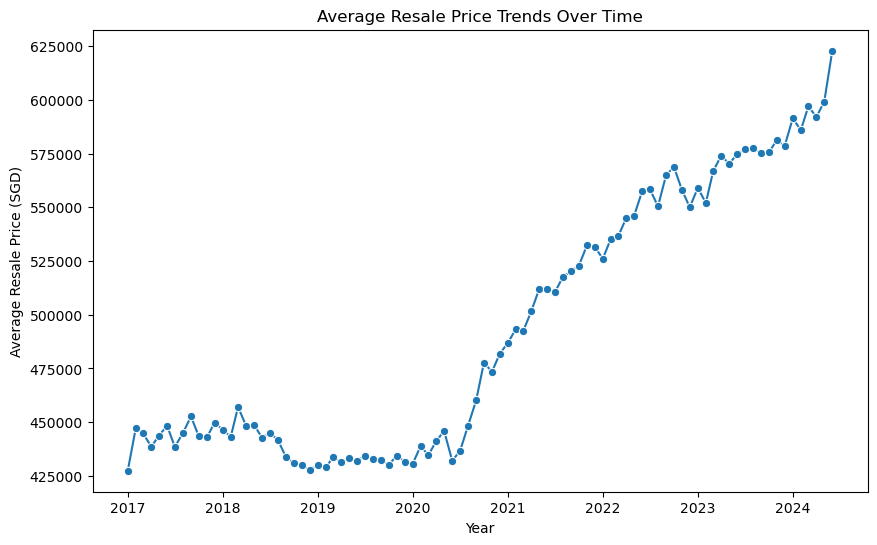

In [82]:
# Plot the line chart
plt.figure(figsize=(10, 6))
sns.lineplot(data=df1.groupby(['date']).agg({'resale_price': 'mean'}).reset_index(), x='date', y='resale_price', marker='o')

plt.xlabel("Year")
plt.ylabel("Average Resale Price (SGD)")
plt.title("Average Resale Price Trends Over Time")
plt.show()

### How do different flat types appreciate or depreciate in value over time?
Plot a line chart of Average Resale Price Over Time by Flat Type

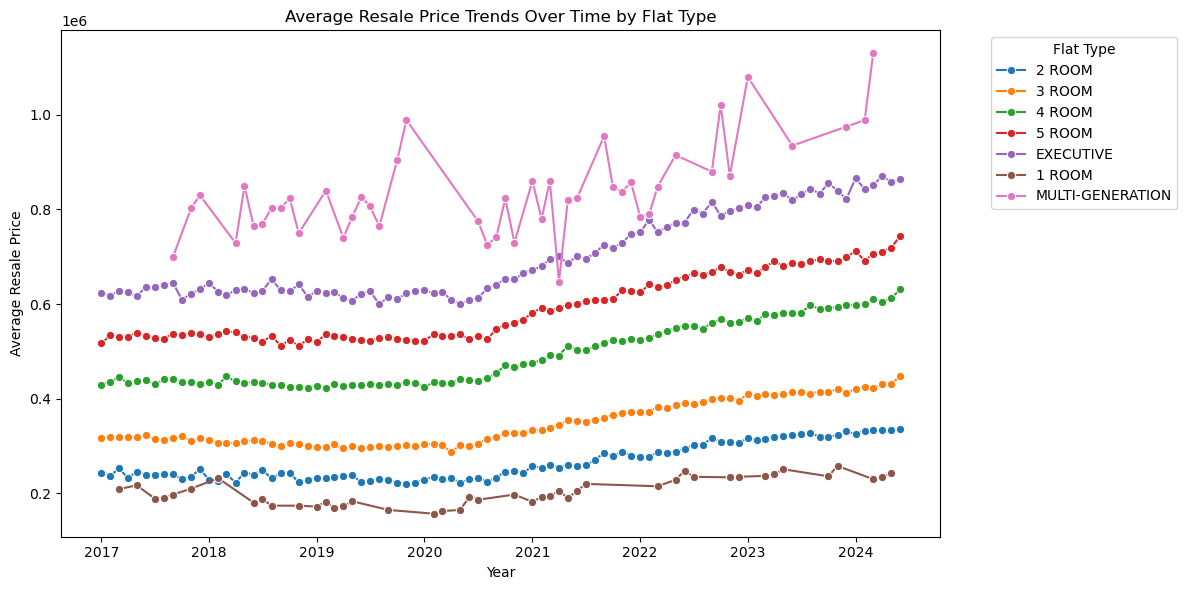

In [85]:
# Plot the line chart
plt.figure(figsize=(12, 6))
sns.lineplot(data=df1.groupby(['date', 'flat_type']).agg({'resale_price': 'mean'}).reset_index(), x='date', y='resale_price', hue='flat_type', marker='o')


plt.xlabel("Year")
plt.ylabel("Average Resale Price")
plt.title("Average Resale Price Trends Over Time by Flat Type")
plt.legend(title="Flat Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### What is the distribution of resale prices by flat type (e.g., 3-room vs. 4-room vs. 5-room)?
Plot a bar chart of Average Resale Price by Flat Type

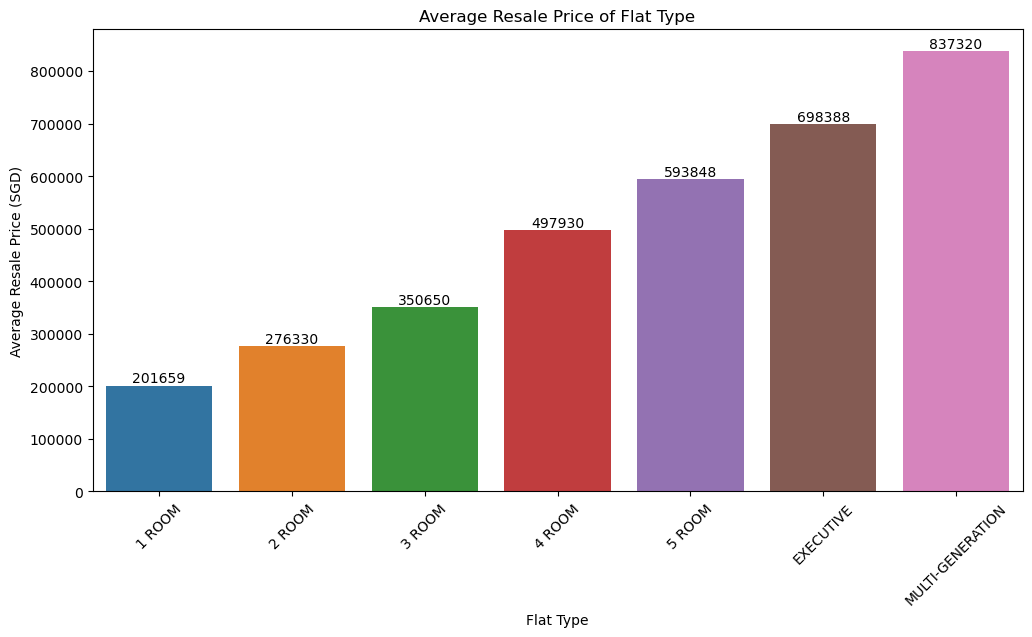

In [57]:
plt.figure(figsize=(12,6))

ax = sns.barplot(data=df1.groupby('flat_type')[['resale_price']].mean().reset_index(), x='flat_type', y='resale_price', hue='flat_type')

for i in ax.containers:
    ax.bar_label(i,)

plt.xlabel('Flat Type')
plt.ylabel('Average Resale Price (SGD)')
plt.title('Average Resale Price of Flat Type')
plt.xticks(rotation=45);

### Which flat type is the most commonly sold?

Plot a bar chart of the count of each flat type sold

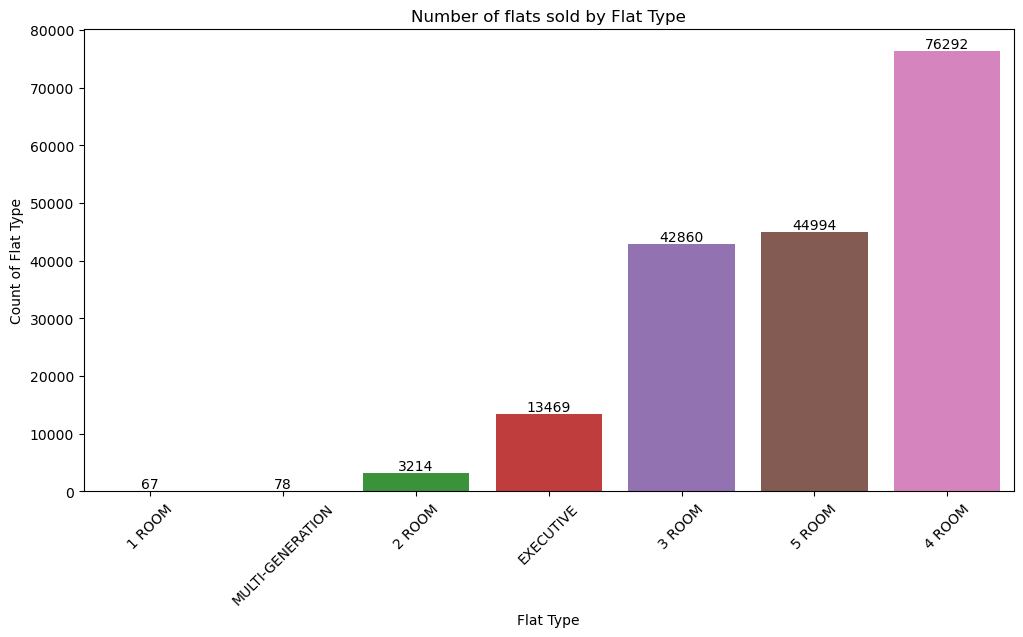

In [66]:
plt.figure(figsize=(12,6))

ax = sns.barplot(data=df1.groupby('flat_type')['resale_price'].count().reset_index().sort_values(by='resale_price'), x='flat_type', y='resale_price', hue='flat_type')

for i in ax.containers:
    ax.bar_label(i,)

plt.xlabel('Flat Type')
plt.ylabel('Count of Flat Type')
plt.title('Number of flats sold by Flat Type')
plt.xticks(rotation=45);

### Which towns have the highest average resale prices (Top 5)?

Plot a bar chart of average resale price by town (Top 5)

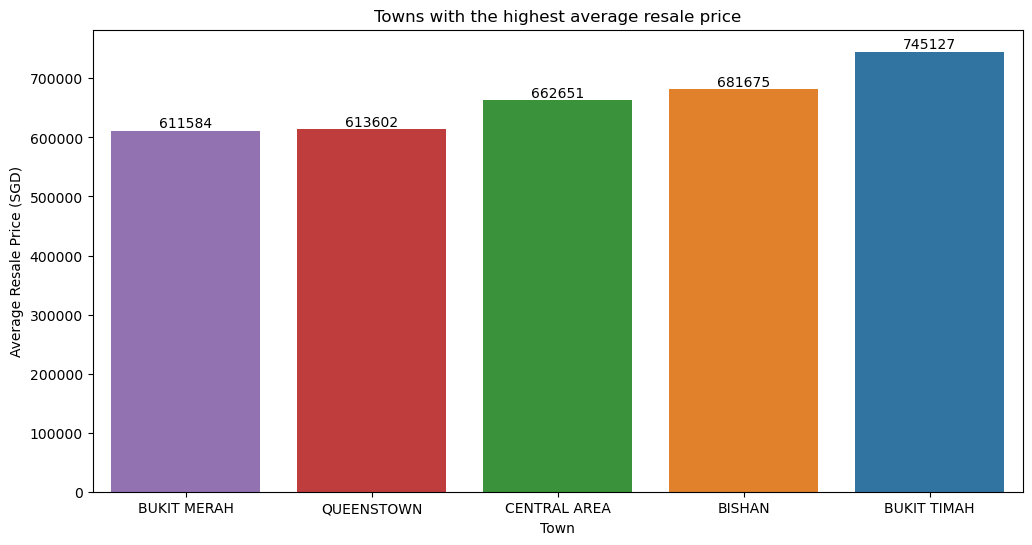

In [118]:
plt.figure(figsize=(12,6))

ax = sns.barplot(data=df1.groupby('town')['resale_price'].mean().reset_index().sort_values(by='resale_price', ascending=False).head(5), x='town', y='resale_price', hue='town')

for i in ax.containers:
    ax.bar_label(i,)

plt.xlabel('Town')
plt.ylabel('Average Resale Price (SGD)')
plt.title('Towns with the highest average resale price')
plt.gca().invert_xaxis();

### Which towns have the lowest average resale prices (Bottom 5)?

Plot a bar chart of average resale price by town (Bottom 5)

Text(0.5, 1.0, 'Towns with the lowest average resale price')

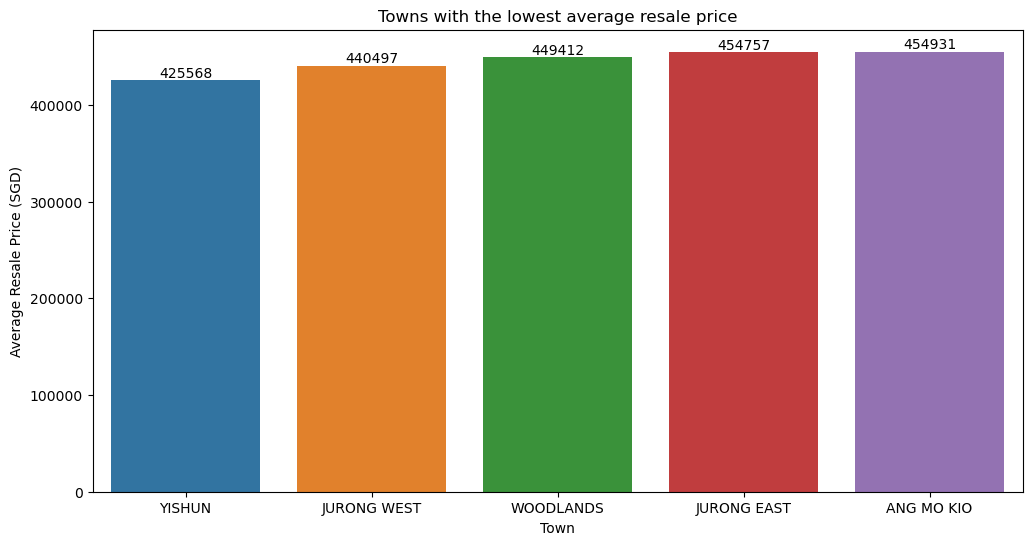

In [117]:
plt.figure(figsize=(12,6))

ax = sns.barplot(data=df1.groupby('town')['resale_price'].mean().reset_index().sort_values(by='resale_price').head(5), x='town', y='resale_price', hue='town')

for i in ax.containers:
    ax.bar_label(i,)

plt.xlabel('Town')
plt.ylabel('Average Resale Price (SGD)')
plt.title('Towns with the lowest average resale price')

### Which areas (street name) have the most expensive flats?

Plot a bar chart of average resale prices by street name and filter by top 10

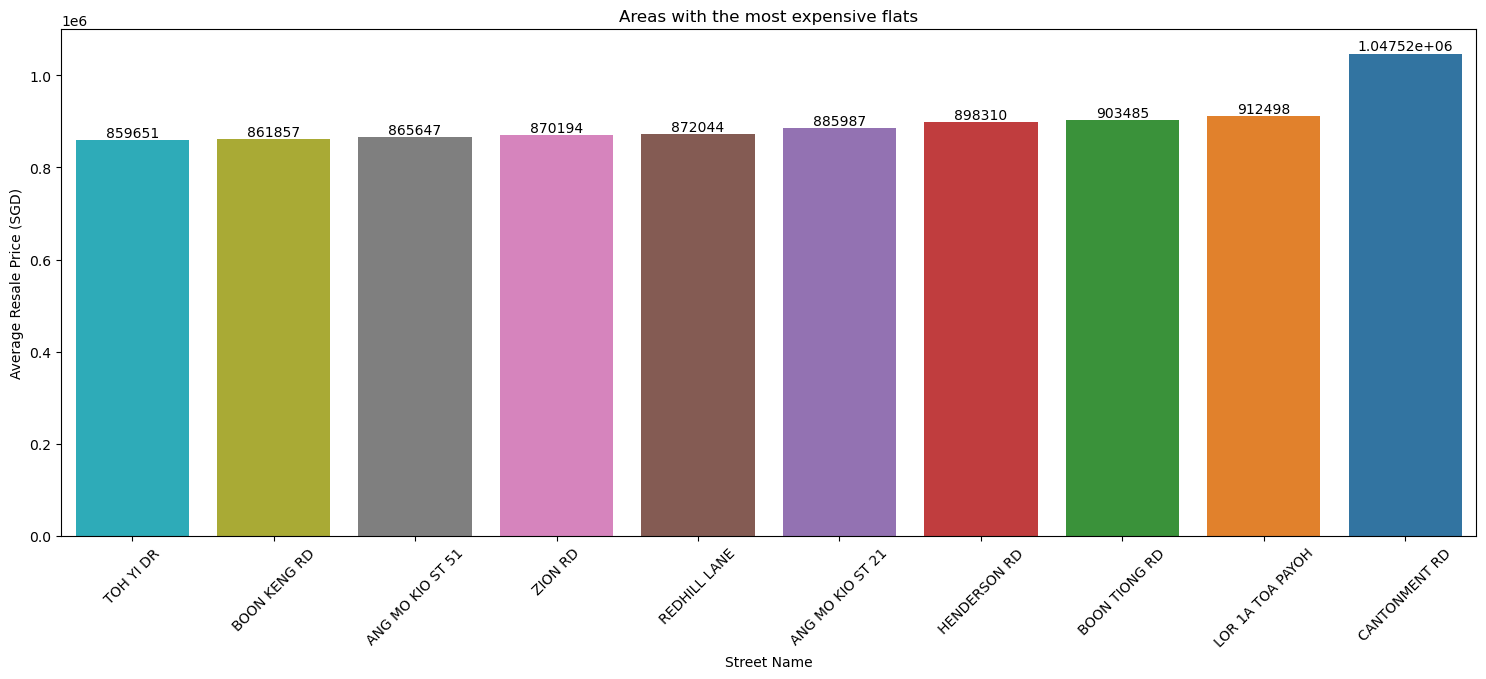

In [113]:
plt.figure(figsize=(15,6))

ax = sns.barplot(data=df1.groupby('street_name')['resale_price'].mean().reset_index().sort_values(by='resale_price', ascending=False).head(10), x='street_name', y='resale_price', hue='street_name')

for i in ax.containers:
    ax.bar_label(i,)

plt.xlabel('Street Name')
plt.ylabel('Average Resale Price (SGD)')
plt.title('Areas with the most expensive flats')
plt.gca().invert_xaxis()
plt.tight_layout()
plt.xticks(rotation=45);

### Which areas (street name) have the least expensive flats?

Plot a bar chart of average resale prices by street name and filter by bottom 10

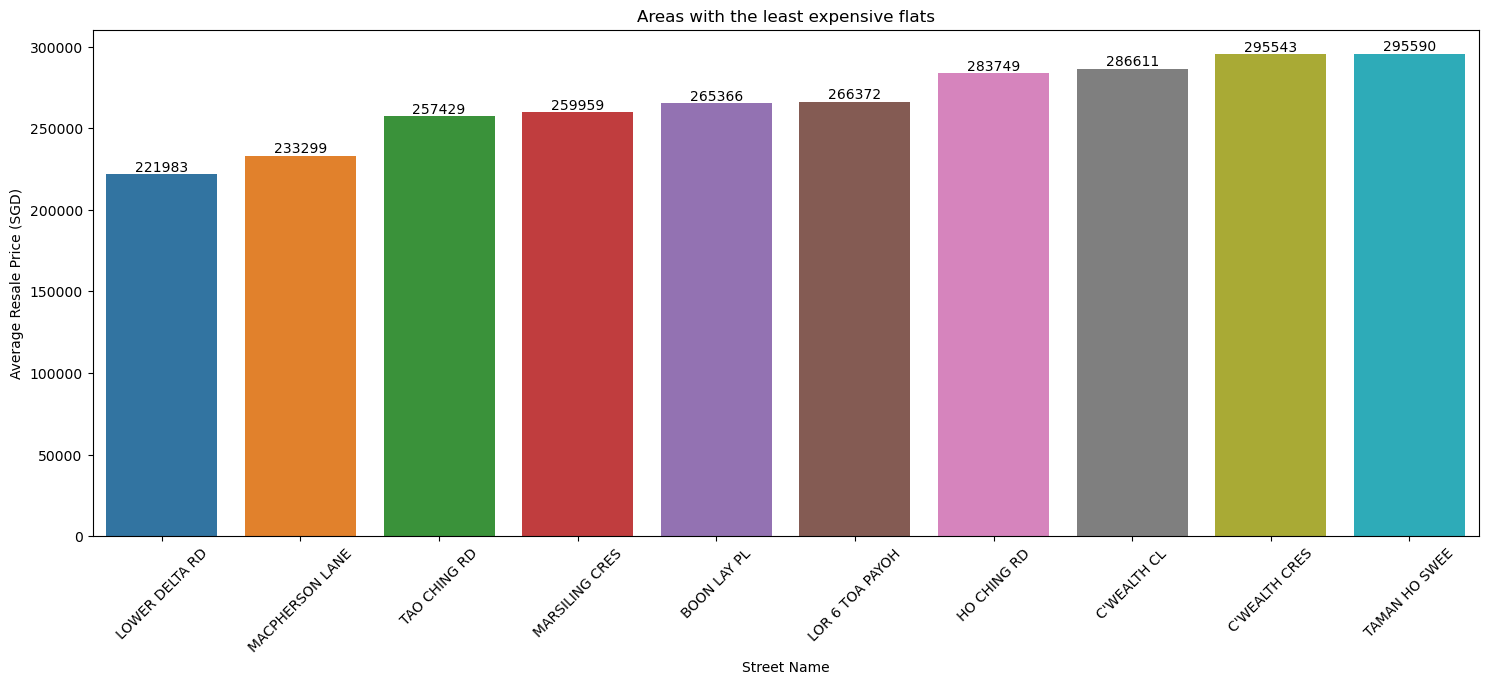

In [120]:
plt.figure(figsize=(15,6))

ax = sns.barplot(data=df1.groupby('street_name')['resale_price'].mean().reset_index().sort_values(by='resale_price').head(10), x='street_name', y='resale_price', hue='street_name')

for i in ax.containers:
    ax.bar_label(i,)

plt.xlabel('Street Name')
plt.ylabel('Average Resale Price (SGD)')
plt.title('Areas with the least expensive flats')
plt.tight_layout()
plt.xticks(rotation=45);

### How do prices vary between regions (North, West, Central, East, North-East)?

Plot a bar chart of average resale price by region

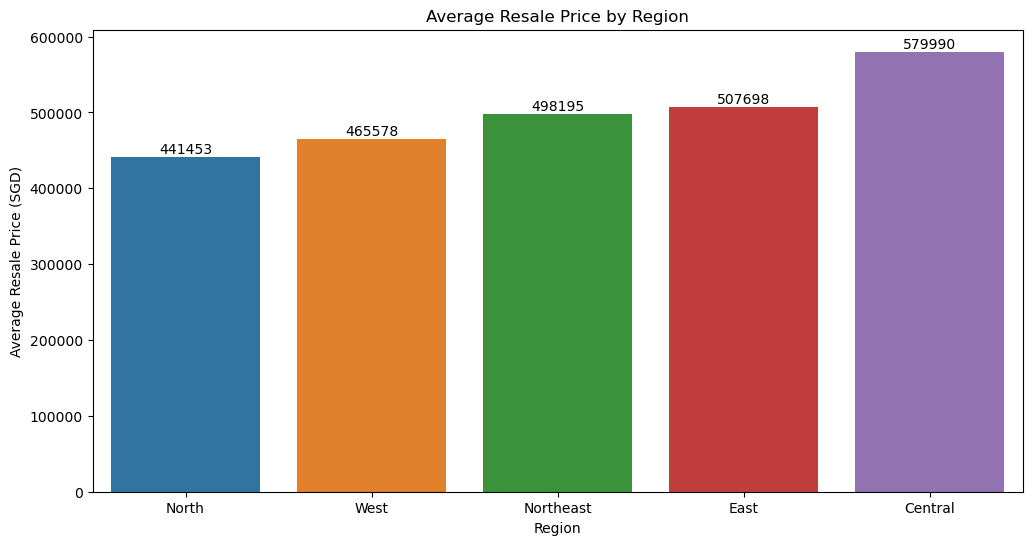

In [125]:
plt.figure(figsize=(12,6))

ax = sns.barplot(data=df1.groupby('region')['resale_price'].mean().reset_index().sort_values(by='resale_price'), x='region', y='resale_price', hue='region')

for i in ax.containers:
    ax.bar_label(i,)

plt.xlabel('Region')
plt.ylabel('Average Resale Price (SGD)')
plt.title('Average Resale Price by Region');

### Do flats located in higher floors generally cost more?

Plot a bar chart of average resale price by storey range

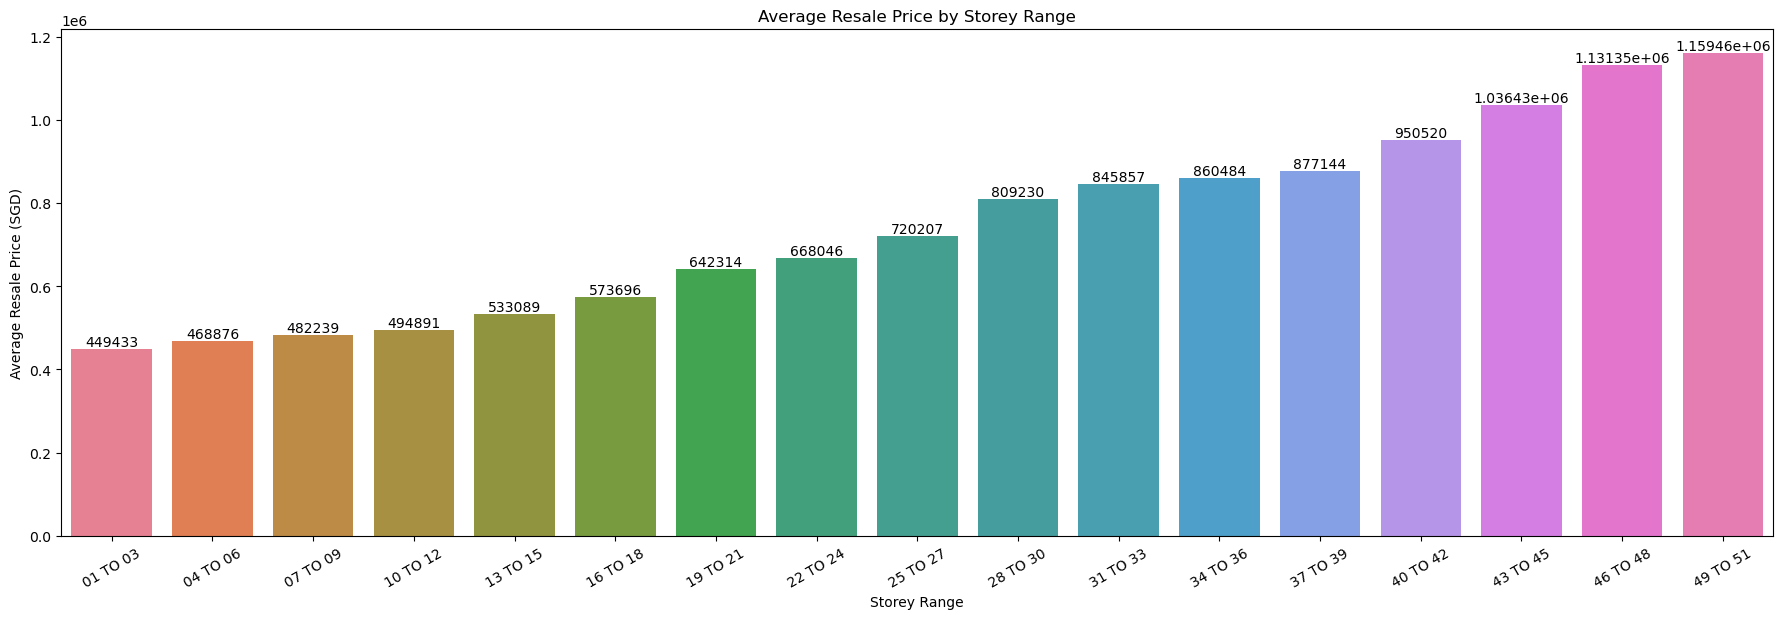

In [132]:
plt.figure(figsize=(18,6))

ax = sns.barplot(data=df1.groupby('storey_range')['resale_price'].mean().reset_index().sort_values(by='resale_price'), x='storey_range', y='resale_price', hue='storey_range')

for i in ax.containers:
    ax.bar_label(i,)

plt.xlabel('Storey Range')
plt.ylabel('Average Resale Price (SGD)')
plt.title('Average Resale Price by Storey Range')
plt.tight_layout()
plt.xticks(rotation=30);

### How does floor area impact resale prices? Is there a correlation between them?

Plot a scatter plot of resale price vs floor area

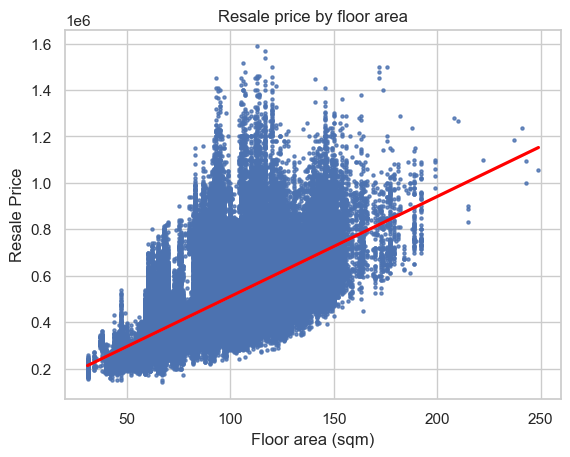

In [134]:
sns.set_theme(style='whitegrid')
sns.regplot(data=df1, x='floor_area_sqm', y='resale_price', scatter_kws={'s':5}, line_kws={'color':'red'})
plt.title("Resale price by floor area")
plt.xlabel('Floor area (sqm)')
plt.ylabel('Resale Price')
plt.show()

### Does lease age impact resale prices?

Plot a line chart of resale price vs lease age

Text(0.5, 1.0, 'Resale Price vs Lease Age')

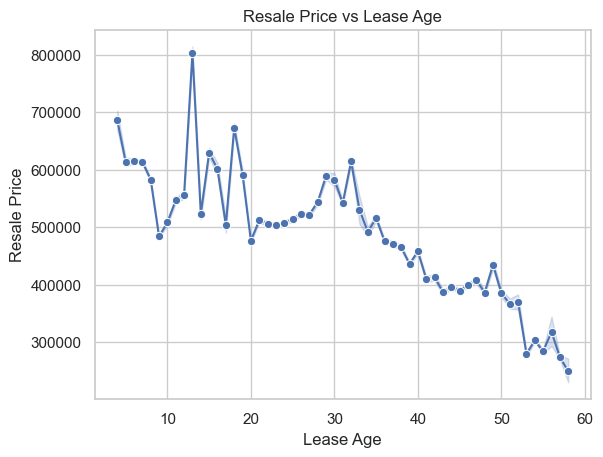

In [ ]:
sns.lineplot(data=df1, x='lease_age', y='resale_price', marker='o')

plt.xlabel('Lease Age')
plt.ylabel('Resale Price')
plt.title('Resale Price vs Lease Age');

## Building a multiple linear regression model

Let's build a multiple linear regression model to determine which factors affect resale prices the most

Since linear regression models are sensitive to outlier values, let's check for outlier values and remove them

On further inspection of the data, we realised that houses with `flat_model` of `Type S2` and `Type S1` and usually more expensive than other houses in Singapore. Furthermore, this houses are only located at `CANTONMENT RD`. Since these houses are not a good representive of the average resale prices of houses in Singapore, let's remove them. 

Houses with the `flat_model` of `Terrace`, `Improved-Maisonette` and `Premium Apartment Loft` are also not your standard HDB houses in Singapore. Hence, we can remove them as well

In [148]:
# Drop houses of Type S2
df2 = df1.loc[df1['flat_model'] != 'Type S2']

In [149]:
# Drop houses of Type S1
df2 = df2.loc[df2['flat_model'] != 'Type S1']

# Drop houses located in CANTONMENT RD
df2 = df2.loc[df2['street_name'] != 'CANTONMENT RD']

# Drop terrace houses
df2 = df2.loc[df2['flat_model'] != 'Terrace']

# Drop Improved-Maisonette houses
df2 = df2.loc[df2['flat_model'] != 'Improved-Maisonette']

# Drop Premium Apartment Loft houses
df2 = df2.loc[df2['flat_model'] != 'Premium Apartment Loft']

### Check outlier values for resale_price

Before we remove outlier values for resale price, we have to consider the flat type of the houses. A 5 ROOM flat will usually be more expensive than a 3 ROOM flat. Hence, we should check outlier values of resale price based on their flat type and then remove them.

In [150]:
def remove_outlier_for_each_flat_type(df, flat_type_list):

    for flat in flat_type_list:
        outlier_flat = df[df['flat_type'] == flat]

        # Compute the 25th percentile value in resale_price
        percentile25_resale_price = outlier_flat['resale_price'].quantile(0.25)

        # Compute the 75th percentile value in resale_price
        percentile75_resale_price = outlier_flat['resale_price'].quantile(0.75)

        # Compute the interquartile range
        iqr_resale_price = percentile75_resale_price - percentile25_resale_price

        # Define the upper limit and lower limit for non-outlier values in resale_price
        upper_limit_resale_price = percentile75_resale_price + 1.5 * iqr_resale_price
        lower_limit_resale_price = percentile25_resale_price - 1.5 * iqr_resale_price
        print(f"-----------{flat}----------")
        print(f"Lower Limit: {lower_limit_resale_price}")
        print(f"Upper Limit: {upper_limit_resale_price}")

        # Identify subset of data containing outliers
        outliers_resale_price = outlier_flat[(outlier_flat['resale_price'] < lower_limit_resale_price) | (outlier_flat['resale_price'] > upper_limit_resale_price)]
        print(f"Number of outlier values for resale prices: {len(outliers_resale_price)}")

        # Drop outlier values from the original dataframe
        df = df.drop(outliers_resale_price.index)

    return df

In [151]:
flat_list = ['2 ROOM', '3 ROOM', '4 ROOM', '5 ROOM', 'EXECUTIVE', 'MULTI-GENERATION']
df2 = remove_outlier_for_each_flat_type(df2, flat_list)

-----------2 ROOM----------
Lower Limit: 104168.0
Upper Limit: 447720.0
Number of outlier values for resale prices: 22
-----------3 ROOM----------
Lower Limit: 129168.0
Upper Limit: 544720.0
Number of outlier values for resale prices: 1747
-----------4 ROOM----------
Lower Limit: 161668.0
Upper Limit: 797220.0
Number of outlier values for resale prices: 3192
-----------5 ROOM----------
Lower Limit: 175000.0
Upper Limit: 975000.0
Number of outlier values for resale prices: 991
-----------EXECUTIVE----------
Lower Limit: 277500.0
Upper Limit: 1097500.0
Number of outlier values for resale prices: 143
-----------MULTI-GENERATION----------
Lower Limit: 550000.0
Upper Limit: 1124000.0
Number of outlier values for resale prices: 1


Storey range seems to play a role in resale prices of houses.

Houses that are situated in high levels tend to be more expensive than houses that are situated in low levels.

Since storey range is a categorical variable and we want to use it to build the model, we can do an ordinal encoding on storey range.

In [161]:
def encode_storey_range(storey_range):
    """Convert storey range to ordinal categories: 1 (Low), 2 (Mid), 3 (High), 4 (Very High)"""
    # Extract the first number in the range (e.g., '10 TO 12' → 10)
    min_storey = int(storey_range.split(" TO ")[0])

    # Assign categories based on storey level
    if min_storey <= 9:
        return 1 # Low level
    elif 10 <= min_storey <= 21:
        return 2 # Mid level
    elif 22 <= min_storey <= 39:
        return 3 # High Level
    else:
        return 4 # Very High level

In [162]:
# Apply the function to create the encoded column
df2["storey_level"] = df2["storey_range"].apply(encode_storey_range)

Let's examine the relationships between resale_price with floor_area_sqm and lease_age with scatterplots

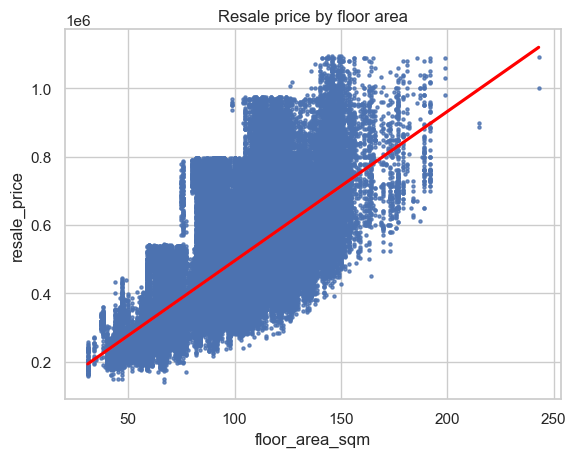

In [156]:
sns.set_theme(style='whitegrid')
sns.regplot(data=df2, x='floor_area_sqm', y='resale_price', scatter_kws={'s':5}, line_kws={'color':'red'})
plt.title("Resale price by floor area")
plt.show()

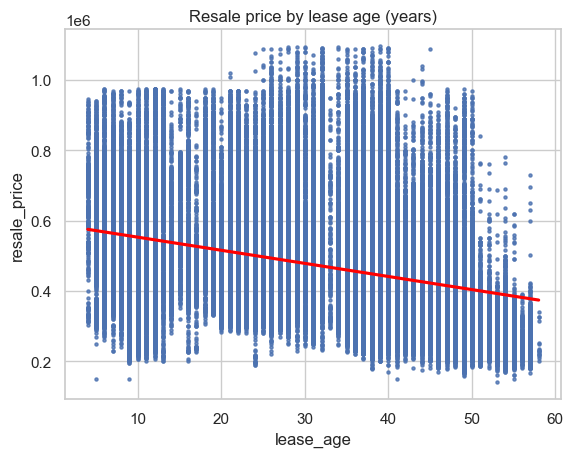

In [158]:
sns.set_theme(style='whitegrid')
sns.regplot(data=df2, x='lease_age', y='resale_price', scatter_kws={'s':5}, line_kws={'color':'red'})
plt.title("Resale price by lease age (years)")
plt.show()

Let's examine the distribution of Resale Prices

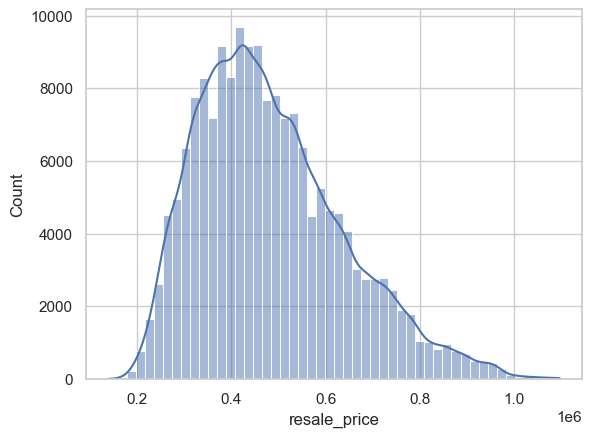

In [159]:
sns.histplot(data=df2['resale_price'], bins=50, kde=True);

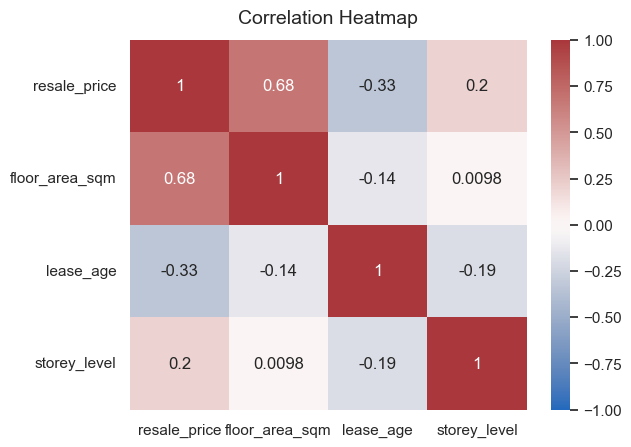

In [166]:
# Plot a correlation heatmap
heatmap = sns.heatmap(df2[['resale_price','floor_area_sqm','lease_age','storey_level']].corr(numeric_only=True), vmin=-1, vmax=1, annot=True, cmap=sns.color_palette("vlag", as_cmap=True))
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':14}, pad=12);

## Fit a multiple linear regression model that predicts resale price

In [167]:
# Set y variable as the variable we want to predict
y = df2[['resale_price']]

# Only select the columns that we want to use in building the linear regression model
X = df2[['flat_type','floor_area_sqm','lease_age','region', 'storey_level']]
X.head()

,flat_type,floor_area_sqm,lease_age,region,storey_level
0,2 ROOM,44.0,45,Northeast,2
1,3 ROOM,67.0,46,Northeast,1
2,3 ROOM,67.0,44,Northeast,1
3,3 ROOM,68.0,44,Northeast,1
4,3 ROOM,67.0,44,Northeast,1


## Pre-process data
Dummy encode the categorical variable

In [183]:
# Get dummies
X = pd.get_dummies(X, drop_first=False)
X.head()

,floor_area_sqm,lease_age,storey_level,flat_type_2 ROOM,flat_type_3 ROOM,flat_type_4 ROOM,flat_type_5 ROOM,flat_type_EXECUTIVE,flat_type_MULTI-GENERATION,region_East,region_North,region_Northeast,region_West
0,44.0,45,2,True,False,False,False,False,False,False,False,True,False
1,67.0,46,1,False,True,False,False,False,False,False,False,True,False
2,67.0,44,1,False,True,False,False,False,False,False,False,True,False
3,68.0,44,1,False,True,False,False,False,False,False,False,True,False
4,67.0,44,1,False,True,False,False,False,False,False,False,True,False


### Split data into training and test sets

Create training and testing sets. The test set should contain 20% of the total samples. Set `random_state=0`.

In [184]:
# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### Fit the model
Instantiate the model and fit it to the training data

In [185]:
# Fit the model to the training model
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

## Evaluate the model

### Train data

Evaluate your model performance by calculating the residual sum of squares and the explained variance score (R^2). Calculate the Mean Absolute Error, Mean Squared Error, and the Root Mean Squared Error.

In [186]:
# Evaluate the model performance on the training data

r_sq = lr.score(X_train, y_train)
print(f"Coefficient of determination: {r_sq}")
y_pred_train = lr.predict(X_train)
print(f"R^2: {r2_score(y_train, y_pred_train)}")
print(f"MAE: {mean_absolute_error(y_train, y_pred_train)}")
print(f"MSE: {mean_squared_error(y_train, y_pred_train)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_train, y_pred_train))}")

Coefficient of determination: 0.6717103980028687
R^2: 0.6717103980028687
MAE: 71617.89940188175
MSE: 7961632986.439734
RMSE: 89227.98320280323


### Test data

Calculate the same metrics on the test data.

In [187]:
# Evaluate the model performance on the testing data

r_sq_test = lr.score(X_test, y_test)
print('Coefficient of determination:', r_sq_test)
y_pred_test = lr.predict(X_test)
print('R^2:', r2_score(y_test, y_pred_test))
print('MAE:', mean_absolute_error(y_test,y_pred_test))
print('MSE:', mean_squared_error(y_test, y_pred_test))
print('RMSE:',np.sqrt(mean_squared_error(y_test, y_pred_test)))

Coefficient of determination: 0.6697979879164853
R^2: 0.6697979879164853
MAE: 71849.06648943112
MSE: 8002795595.142929
RMSE: 89458.34558688714


### Results

Get the `actual`,`predicted`, and `residual` for the testing set, and store them as columns in a `results` dataframe.

In [188]:
# Create a `results` dataframe

results = pd.DataFrame(data={'actual': y_test['resale_price'],
                             'predicted': y_pred_test.ravel()})
results['residual'] = results['actual'] - results['predicted']

In [189]:
results.head()

,actual,predicted,residual
56818,908000.0,707902.155441,200097.844559
145122,570000.0,543065.601129,26934.398871
32591,460000.0,649914.904147,-189914.904147
37024,220000.0,292363.458758,-72363.458758
162638,516000.0,431405.776086,84594.223914


### Visualize model results

Create a scatterplot to visualize `actual` vs. `predicted`.

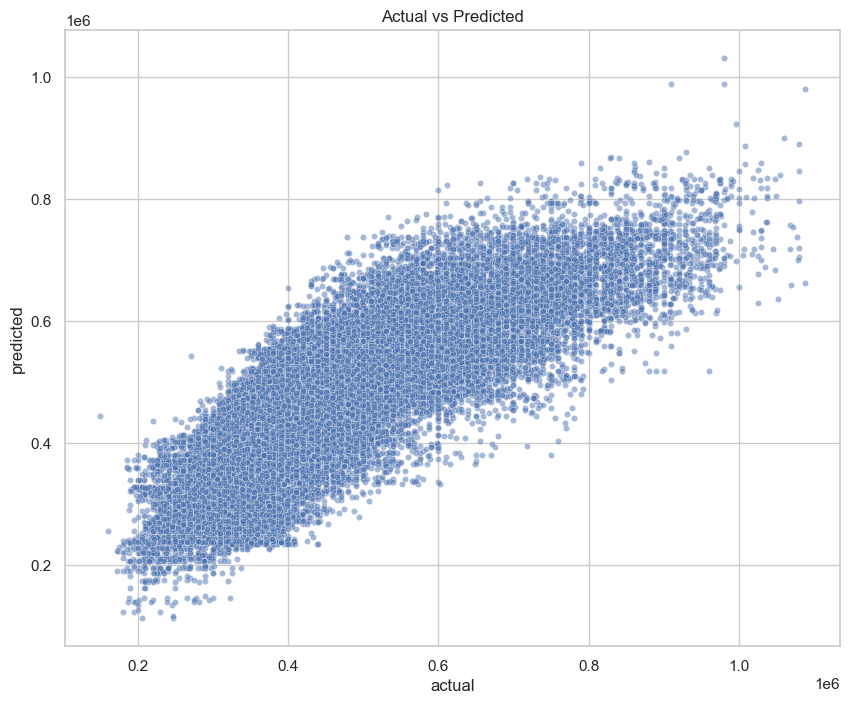

In [175]:
# Create scatterplot to visualize actual vs predicted
plt.figure(figsize=(10,8))
sns.set_theme(style='whitegrid')
sns.scatterplot(x='actual', y='predicted', data=results, alpha=0.5, s=20)


plt.title("Actual vs Predicted");

## Model Assumptions: No multicollinearity
1. Check for multicollinearity among independent numerical variables

In [176]:
# Select numerical features
X_numerical = df2[['floor_area_sqm','lease_age']]

# Compute VIF for each feature
vif = [variance_inflation_factor(X_numerical.values, i) for i in range(X_numerical.shape[1])]

# Create a DataFrame with the VIF results for the column names in X.
df_vif = pd.DataFrame(vif, index=X_numerical.columns, columns = ['VIF'])

df_vif

,VIF
floor_area_sqm,3.800474
lease_age,3.800474


Since lease_age and remaining_lease_months measure the same thing, are likely correlated and lease_age gives a better model performance, let's drop remaining_lease_months and use lease_age instead

We get a VIF of 3.726896 which is less than 5.
VIF < 5 indicates a low multicollinearity. Hence, we can conclude that the no multicollinearity assumption is met

## Model Assumptions: Linearity
Create scatterplots comparing the continuous independent variables selected previously with `resale_price` to check the linearity assumption. Use a pairplot to verify the linearity assumption or create new scatterplots comparing the variables of interest.

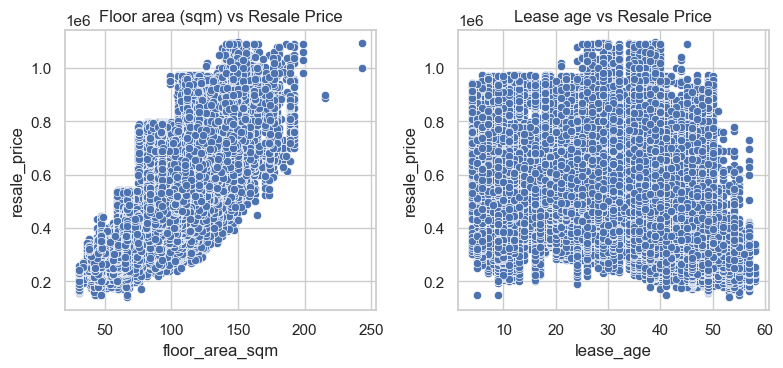

In [177]:
fig, axes = plt.subplots(1,2, figsize=(8,4))

sns.scatterplot(x=df2['floor_area_sqm'], y=df2['resale_price'], ax=axes[0])
axes[0].set_title('Floor area (sqm) vs Resale Price')

sns.scatterplot(x=df2['lease_age'], y=df2['resale_price'], ax=axes[1])
axes[1].set_title('Lease age vs Resale Price')

plt.tight_layout()

The linearity assumption holds for `floor_area_sqm`, as there is a strong linear relationship in the scatterplot between Floor area and Resale Price. However, there is only a moderate negative linear relationship between lease age and resale price

## Model Assumption: Independence

The **independent observation assumption** states that each observation in the dataset is independent. As each row is independent from one another, the independence assumption is not violated.

## Model Assumption: Normality

Create the following plots to check the **normality assumption**:

* **Plot 1**: Histogram of the residuals
* **Plot 2**: Q-Q plot of the residuals

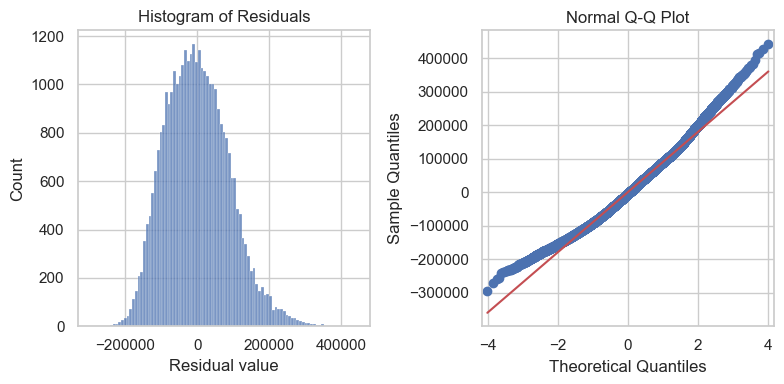

In [178]:
# Create a histogram with the residuals. 
fig, axes = plt.subplots(1,2, figsize=(8,4))

sns.histplot(data=results['residual'], ax=axes[0])
axes[0].set_title('Histogram of Residuals')
axes[0].set_xlabel('Residual value')


# Create a Q-Q plot of the residuals.
sm.qqplot(data=results['residual'], ax=axes[1], line='s')
axes[1].set_title('Normal Q-Q Plot')
plt.tight_layout()
plt.show()

The histogram of the residuals are approximately normally distributed with a slight skew to the right. The residuals in the Q-Q plot curves slightly upwards at the end. This suggests that there are still some high outlier values affecting the normality.

We can further remove outlier values before building the model again.

## Model Assumption: Constant Variance

Check that the **constant variance assumption** is not violated by creating a scatterplot with the fitted values and residuals. Add a line at $y = 0$ to visualize the variance of residuals above and below $y = 0$.

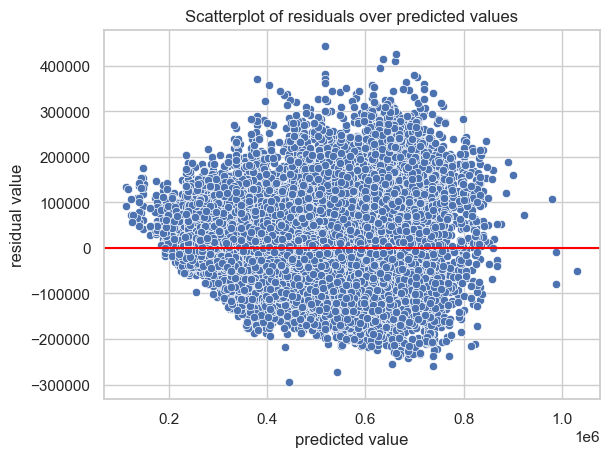

In [179]:
# Create a scatterplot of `residuals` over `predicted`

sns.scatterplot(x=results['predicted'], y=results['residual'])
plt.axhline(0, c='red')
plt.title('Scatterplot of residuals over predicted values')
plt.xlabel('predicted value')
plt.ylabel('residual value')
plt.show()

It looks like the scatterplot looks similarly distributed and randomly spread which satisfies the constant variance assumption

## Coefficients

Use the `coef_` attribute to get the model's coefficients. The coefficients are output in the order of the features that were used to train the model. Which feature had the greatest effect on resale price?

In [190]:
# Output the model's coefficients

coefficients = pd.DataFrame(lr.coef_, columns=X.columns)
coefficients

,floor_area_sqm,lease_age,storey_level,flat_type_2 ROOM,flat_type_3 ROOM,flat_type_4 ROOM,flat_type_5 ROOM,flat_type_EXECUTIVE,flat_type_MULTI-GENERATION,region_East,region_North,region_Northeast,region_West
0,3556.862644,-3988.272432,32864.814404,24082.98837,64767.42729,77403.995008,98671.89346,150081.754656,246296.515935,-98058.988439,-185059.631934,-134508.353772,-160457.095671


These coefficients reveal that flat type was the feature with the greatest weight in the model's final prediction.

A multi-generation flat type increases the resale price by a mean of $246296.

For every increase in floor area, resale price will go up by a mean of $3556.

For every increase in lease age, resale price will also go down by a mean of $3988.

When storey level goes from a lower level to a higher level, resale price will go up by a mean of $32864.

Houses in the Central region are the most expensive while houses in the North region are the least expensive.